In [1]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=f72ce8457654d2eba9b44176836cf47528c776769a7f5b4d7a9a46ac43912898
  Stored in directory: /root/.cache/pip/wheels/65/9b/15/cb1e6b279c14ed897530d15cfd7da8e3df8a947e593f5cfe59
Successfully built tflearn


In [2]:
import os
from zipfile import ZipFile
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import tensorflow as tf
import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from keras.applications import MobileNet
import tflearn.datasets.oxflower17 as oxflower17

import warnings
warnings.filterwarnings("ignore")

plt.grid(None)
le=LabelEncoder()
random_state=42
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Instructions for updating:
non-resource variables are not supported in the long term


Mounted at /content/drive


################################

# PART-A

################################

## 1. Import and Understand the data

### A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python.

In [3]:
# Extracting all the folders of the zip
ZipFile('/content/drive/My Drive/GL/plant-seedlings-classification.zip').extractall()

### B. Map the images from train folder with train labels to form a DataFrame.

In [4]:
# Train folder
train_dir='plant-seedlings-classification/train'
plant_list=[]
for folder in os.listdir(train_dir):
    folder_dir=os.path.join(train_dir,folder)
    if not os.path.isdir(folder_dir):
        continue
    for img_file in os.listdir(folder_dir):
        img_path=os.path.join(folder_dir,img_file)
        with Image.open(img_path) as image:
            width, height = image.size
        plant_list.append([img_file, folder, img_path, height, width])

# Creating dataframe
plant_df=pd.DataFrame(plant_list,columns=['name','species','image','height','width'])
plant_df

,name,species,image,height,width
0,e54767587.png,Small-flowered Cranesbill,plant-seedlings-classification/train/Small-flo...,625,625
1,cd4bcc457.png,Small-flowered Cranesbill,plant-seedlings-classification/train/Small-flo...,711,711
2,4bc35381d.png,Small-flowered Cranesbill,plant-seedlings-classification/train/Small-flo...,209,209
3,3993a9c5c.png,Small-flowered Cranesbill,plant-seedlings-classification/train/Small-flo...,145,145
4,89d260299.png,Small-flowered Cranesbill,plant-seedlings-classification/train/Small-flo...,287,287
...,...,...,...,...,...
4745,8129d97cd.png,Sugar beet,plant-seedlings-classification/train/Sugar bee...,96,96
4746,b8418755e.png,Sugar beet,plant-seedlings-classification/train/Sugar bee...,651,651
4747,58debe1da.png,Sugar beet,plant-seedlings-classification/train/Sugar bee...,631,631
4748,25d60e020.png,Sugar beet,plant-seedlings-classification/train/Sugar bee...,311,311


### C. Write a function that will select n random images and display images along with its species.

Provide value for random images display5


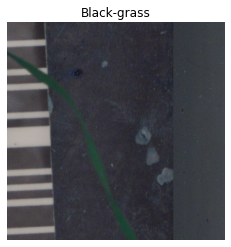

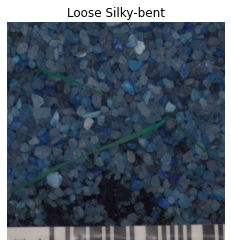

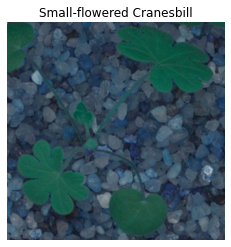

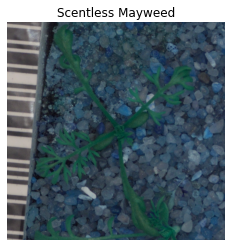

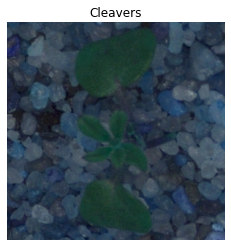

In [5]:
n=input("Provide value for random images display")
for index, row in plant_df.sample(int(n),random_state=random_state).iterrows():
    img = cv2.imread(row['image'], cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.title(row['species'])
    plt.axis('off')
    plt.show()

## 2. Data preprocessing

### A. Create X & Y from the DataFrame.
### B. Encode labels of the images.
### C. Unify shape of all the images.
### D. Normalise all the images.

In [6]:
plant_count=plant_df['species'].value_counts().sort_values(ascending=True)
plant_count

Common wheat                 221
Maize                        221
Shepherds Purse              231
Black-grass                  263
Cleavers                     287
Sugar beet                   385
Charlock                     390
Fat Hen                      475
Small-flowered Cranesbill    496
Scentless Mayweed            516
Common Chickweed             611
Loose Silky-bent             654
Name: species, dtype: int64

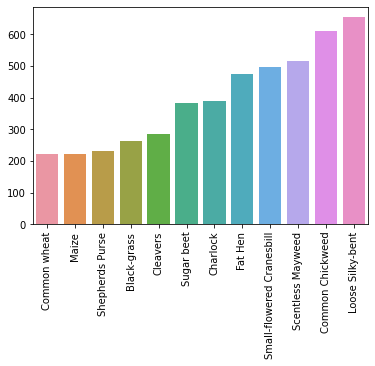

In [7]:
sns.barplot(x=plant_count.keys(),y=plant_count.values)
plt.xticks(rotation=90)
plt.show()

In [8]:
# Formatting i/ps for X and normalizing pixels to grayScale
plant_img_list=[]
def convert(filename):
    # Converting image to array
    cv_img=cv2.imread(filename)

    # Unifying all images to same height and width and then normalizing pixels
    plant_img_list.append(cv2.resize(cv_img, (150,150), interpolation = cv2.INTER_AREA).astype('float32')/255.0)

plant_df['image'].apply(convert)
X_plant=np.array(plant_img_list)

In [9]:
# Encoding labels of the images
y_plant=plant_df['species']
y_plant=le.fit_transform(y_plant)
y_plant=np_utils.to_categorical(y_plant)

In [10]:
# X_plant and y_plant dataframe has been created for further analysis
X_plant.shape, y_plant.shape

((4750, 150, 150, 3), (4750, 12))

## 3. Model training

### A. Split the data into train and test data.

In [11]:
X_plant_train,X_plant_test,y_plant_train,y_plant_test = train_test_split(X_plant,y_plant,test_size=0.2,random_state=random_state, stratify=y_plant)

In [12]:
print('X_train dataset: ',X_plant_train.shape)
print('X_test dataset: ',X_plant_test.shape)
print('y_train dataset: ',y_plant_train.shape)
print('y_test dataset: ',y_plant_test.shape)

X_train dataset:  (3800, 150, 150, 3)
X_test dataset:  (950, 150, 150, 3)
y_train dataset:  (3800, 12)
y_test dataset:  (950, 12)


### B. Create new CNN architecture to train the model.
### C. Train the model on train data and validate on test data.

In [13]:
backend.clear_session()
tf.random.set_seed(random_state)

# Initialising CNN classifier
plant_classifier=Sequential()

# Add a Convolution layer with 256 kernels of 3X3 shape with activation function ReLU
plant_classifier.add(Conv2D(filters=256, kernel_size=(3,3), input_shape=(150,150,3), activation='relu',padding='same'))
plant_classifier.add(MaxPooling2D(pool_size = (2, 2))) # Add a Max Pooling layer of size 2X2
plant_classifier.add(BatchNormalization(axis=3))
plant_classifier.add(Dropout(0.2))


# Add another Convolution layer with 128 kernels of 3X3 shape with activation function ReLU
plant_classifier.add(Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu', padding = 'same'))
plant_classifier.add(MaxPooling2D(pool_size = (2, 2)))
plant_classifier.add(BatchNormalization(axis=3))
plant_classifier.add(Dropout(0.2))

# Add another Convolution layer with 64 kernels of 3X3 shape with activation function ReLU
plant_classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu', padding = 'same'))
plant_classifier.add(MaxPooling2D(pool_size = (2, 2)))
plant_classifier.add(BatchNormalization(axis=3))
plant_classifier.add(Dropout(0.2))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
plant_classifier.add(Conv2D(filters=32, kernel_size=(3, 3), activation = 'relu', padding = 'same'))
plant_classifier.add(MaxPooling2D(pool_size = (2, 2)))
plant_classifier.add(BatchNormalization(axis=3))
plant_classifier.add(Dropout(0.2))

# Flattening the layer before fully connected layers
plant_classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
plant_classifier.add(Dense(units = 512, activation = 'relu'))
plant_classifier.add(BatchNormalization())
plant_classifier.add(Dropout(0.2))

# Adding a fully connected layer with 256 neurons
plant_classifier.add(Dense(units = 256, activation = 'relu'))
plant_classifier.add(BatchNormalization())
plant_classifier.add(Dropout(0.2))

# The final output layer with 5 neuron to predict the categorical classification
plant_classifier.add(Dense(units = 12, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
plant_classifier.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
## Looking into our base model
plant_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 256)      1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 75, 75, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0

In [16]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks = [checkpoint,reduce_lr]

In [17]:
# Fit the model
plant_history=plant_classifier.fit(X_plant_train, y_plant_train, validation_data=(X_plant_test, y_plant_test) , epochs=50, batch_size=50, verbose=1, callbacks=callbacks)

Train on 3800 samples, validate on 950 samples
Epoch 1/50
3800/3800 [==============================] - ETA: 0s - loss: 1.8663 - acc: 0.4268
Epoch 1: saving model to model_weights.h5
3800/3800 [==============================] - 42s 11ms/sample - loss: 1.8663 - acc: 0.4268 - val_loss: 6.8683 - val_acc: 0.0684 - lr: 0.0010
Epoch 2/50
3800/3800 [==============================] - ETA: 0s - loss: 0.9068 - acc: 0.7005
Epoch 2: saving model to model_weights.h5
3800/3800 [==============================] - 30s 8ms/sample - loss: 0.9068 - acc: 0.7005 - val_loss: 12.1467 - val_acc: 0.1379 - lr: 0.0010
Epoch 3/50
3800/3800 [==============================] - ETA: 0s - loss: 0.6135 - acc: 0.7955
Epoch 3: saving model to model_weights.h5
3800/3800 [==============================] - 30s 8ms/sample - loss: 0.6135 - acc: 0.7955 - val_loss: 10.8217 - val_acc: 0.1379 - lr: 0.0010
Epoch 4/50
3800/3800 [==============================] - ETA: 0s - loss: 0.4286 - acc: 0.8566
Epoch 4: saving model to model_weig

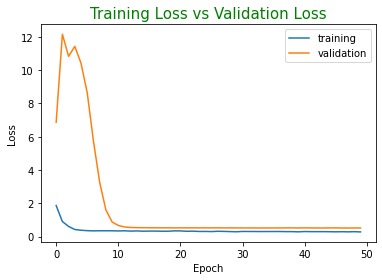

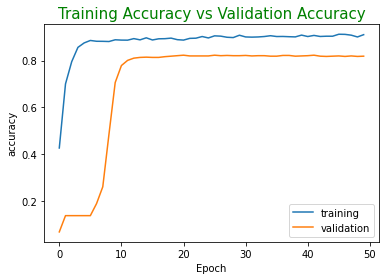

In [18]:
# Capturing learning history per epoch
plant_hist  = pd.DataFrame(plant_history.history)
plant_hist['epoch'] = plant_history.epoch

# Plotting Loss at different epochs
plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
plt.plot(plant_hist['loss'])
plt.plot(plant_hist['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

# Plotting Accuracy at different epochs
plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
plt.plot(plant_hist['acc'])
plt.plot(plant_hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

In [19]:
# calculate score of training data
plant_classifier.evaluate(X_plant_train, y_plant_train, batch_size=50, verbose=1)

[0.26601746247002955, 0.9142105]

In [20]:
# calculate score of testing data
plant_classifier.evaluate(X_plant_test, y_plant_test, batch_size=50, verbose=1)

[0.5189936474749917, 0.8189474]

In [21]:
# Predicting for X_plant_test
y_plant_pred=plant_classifier.predict(X_plant_test)
y_plant_pred

array([[1.2601501e-03, 1.4930776e-02, 9.1679576e-05, ..., 2.6417658e-04,
        6.2672712e-04, 9.7071302e-01],
       [4.0837051e-05, 9.8057783e-01, 1.0957099e-03, ..., 4.7407221e-04,
        9.3239845e-07, 2.6312224e-03],
       [2.2207509e-05, 7.3642057e-01, 1.6110517e-03, ..., 1.5673632e-03,
        2.4190472e-01, 1.7393960e-02],
       ...,
       [5.1283510e-04, 6.1885796e-02, 2.9473554e-04, ..., 8.7114203e-01,
        6.0236440e-03, 1.0108560e-03],
       [9.1096445e-06, 5.1990676e-01, 4.7898203e-01, ..., 9.3696178e-07,
        1.4668307e-05, 1.9968178e-05],
       [5.6548466e-05, 1.3308537e-03, 9.8816699e-01, ..., 2.1948731e-06,
        3.2279627e-06, 1.7037476e-06]], dtype=float32)

In [22]:
y_plant_pred_final=np.argmax(y_plant_pred, axis = 1)
y_plant_check_test = np.argmax(y_plant_test, axis = 1)

In [23]:
print('Classification Report')
print(classification_report(y_plant_check_test,y_plant_pred_final))

Classification Report
              precision    recall  f1-score   support

           0       0.57      0.47      0.52        53
           1       0.94      0.92      0.93        78
           2       0.95      0.90      0.92        58
           3       0.94      0.70      0.80       122
           4       0.77      0.91      0.83        44
           5       0.79      0.88      0.83        95
           6       0.82      0.78      0.80       131
           7       0.93      0.61      0.74        44
           8       0.66      0.97      0.79       103
           9       0.79      0.67      0.73        46
          10       0.88      0.90      0.89        99
          11       0.88      0.92      0.90        77

    accuracy                           0.82       950
   macro avg       0.83      0.80      0.81       950
weighted avg       0.83      0.82      0.82       950



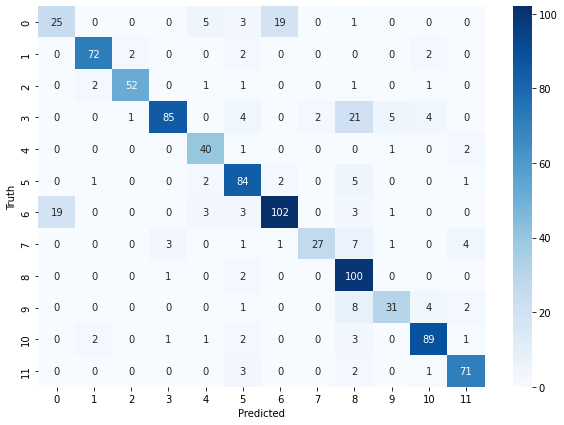

In [24]:
cm=confusion_matrix(y_plant_check_test,y_plant_pred_final)

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### D. Select a random image and print actual label and predicted label for the same.

Provide value for random images to compare5


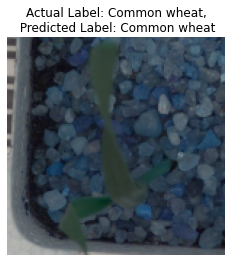

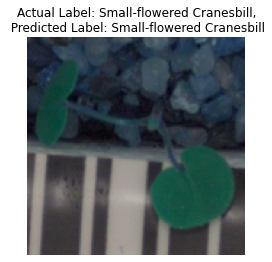

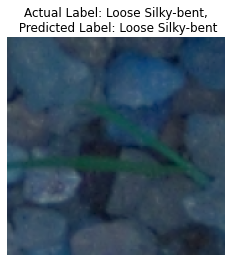

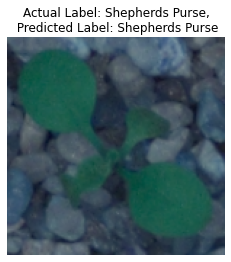

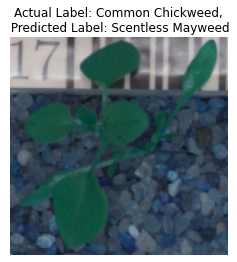

In [25]:
val=input("Provide value for random images to compare")
np.random.seed(random_state)
rand_idx = np.random.randint(low=0,high=y_plant_check_test.shape[0],size=int(val))

for i in rand_idx:
  plt.imshow(X_plant_test[i])
  plt.title("Actual Label: {},\n Predicted Label: {}".format(le.classes_[y_plant_check_test[i]], le.classes_[y_plant_pred_final[i]]))
  plt.axis('off')
  plt.show()

In [26]:
del plant_classifier,plant_hist, plant_history

################################

# PART-B

################################

## 1. Import and Understand the data

### A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading.
### B. Print Number of images and shape of the images.

In [27]:
X, y = oxflower17.load_data()
X.shape, y.shape

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


((1360, 224, 224, 3), (1360,))

oxflower17 dataset contains 1360 colour images with 224 pixel height and 224 pixel width and RGB as channel.

### C. Print count of each class from y.

In [28]:
pd.Series(y).value_counts().sort_index()

0     80
1     80
2     80
3     80
4     80
5     80
6     80
7     80
8     80
9     80
10    80
11    80
12    80
13    80
14    80
15    80
16    80
dtype: int64

There are 17 labels for dataset and all labels are having equal number of data distributed i.e. 80.

## 2. Image Exploration & Transformation [Learning purpose - Not related to final model]

### A. Display 5 random images.

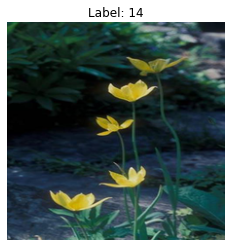

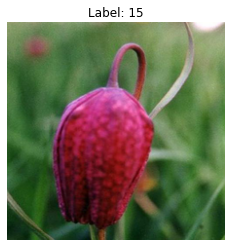

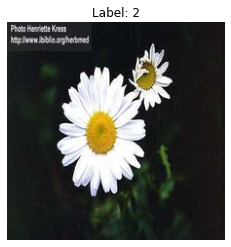

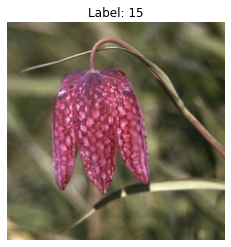

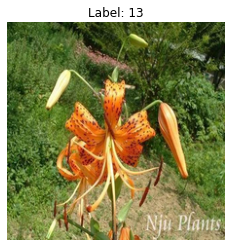

In [29]:
np.random.seed(random_state)
rand_idx = np.random.randint(low=0,high=X.shape[0],size=5)

for i in rand_idx:
  plt.imshow(X[i])
  plt.title("Label: {}".format(y[i]))
  plt.axis('off')
  plt.show()

### B. Select any image from the dataset and assign it to a variable.

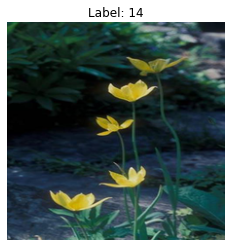

In [30]:
np.random.seed(random_state)
rand_idx = np.random.randint(low=0,high=X.shape[0],size=1)[0]

X_rand_img=X[rand_idx]
y_rand_img=y[rand_idx]

plt.imshow(X_rand_img)
plt.title("Label: {}".format(y_rand_img))
plt.axis('off')
plt.show()

### C. Transform the image into grayscale format and display the same.

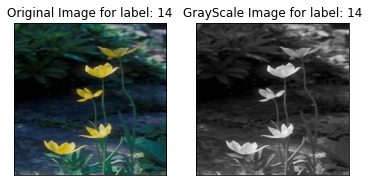

In [31]:
gray_scale_img=cv2.cvtColor(X_rand_img, cv2.COLOR_RGB2GRAY)

plt.subplot(121),plt.imshow(X_rand_img),plt.title('Original Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(gray_scale_img, cmap='gray'),plt.title('GrayScale Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.show()

### D. Apply a filter to sharpen the image and display the image before and after sharpening.

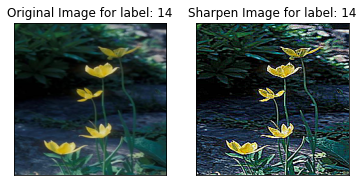

In [32]:
sharpen_filter=np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharp_image=cv2.filter2D(X_rand_img,-1,sharpen_filter)

plt.subplot(121),plt.imshow(X_rand_img),plt.title('Original Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(sharp_image),plt.title('Sharpen Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.show()

### E. Apply a filter to blur the image and display the image before and after blur.

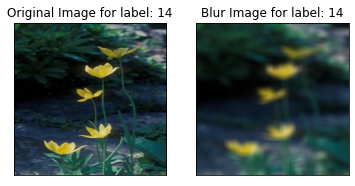

In [33]:
blur_image=cv2.blur(X_rand_img,(10,10),cv2.BORDER_DEFAULT)

plt.subplot(121),plt.imshow(X_rand_img),plt.title('Original Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur_image),plt.title('Blur Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.show()

### F. Display all the 4 images from above questions besides each other to observe the difference.

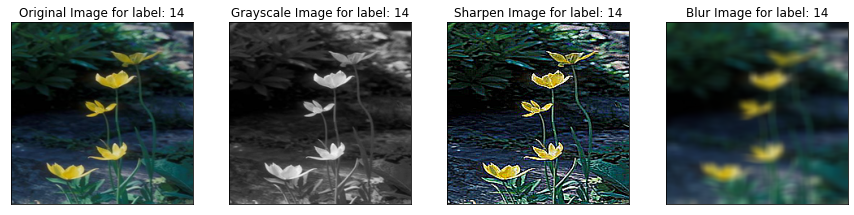

In [34]:
plt.figure(figsize=(15,7))
plt.subplot(1,4,1),plt.imshow(X_rand_img),plt.title('Original Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.subplot(1,4,2),plt.imshow(gray_scale_img, cmap='gray'),plt.title('Grayscale Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.subplot(1,4,3),plt.imshow(sharp_image),plt.title('Sharpen Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.subplot(1,4,4),plt.imshow(blur_image),plt.title('Blur Image for label: {}'.format(y_rand_img))
plt.xticks([]), plt.yticks([])
plt.show()

As per the different filters, image quality is changing.

## 3. Model training and Tuning

### A. Split the data into train and test with 80:20 proportion.

In [35]:
X_flower_train,X_flower_test,y_flower_train,y_flower_test = train_test_split(X,y,test_size=0.2,random_state=random_state, stratify=y)

In [36]:
print('X_train dataset: ',X_flower_train.shape)
print('X_test dataset: ',X_flower_test.shape)
print('y_train dataset: ',y_flower_train.shape)
print('y_test dataset: ',y_flower_test.shape)

X_train dataset:  (1088, 224, 224, 3)
X_test dataset:  (272, 224, 224, 3)
y_train dataset:  (1088,)
y_test dataset:  (272,)


### B. Train a model using any Supervised Learning algorithm and share performance metrics on test data.

In [37]:
X_flower_svm_train=X_flower_train.reshape((X_flower_train.shape[0],224*224*3))
X_flower_svm_test=X_flower_test.reshape((X_flower_test.shape[0],224*224*3))

X_flower_svm_train.shape,X_flower_svm_test.shape

((1088, 150528), (272, 150528))

Accuracy score Training dataset:1.00
Accuracy score Testing dataset:0.13


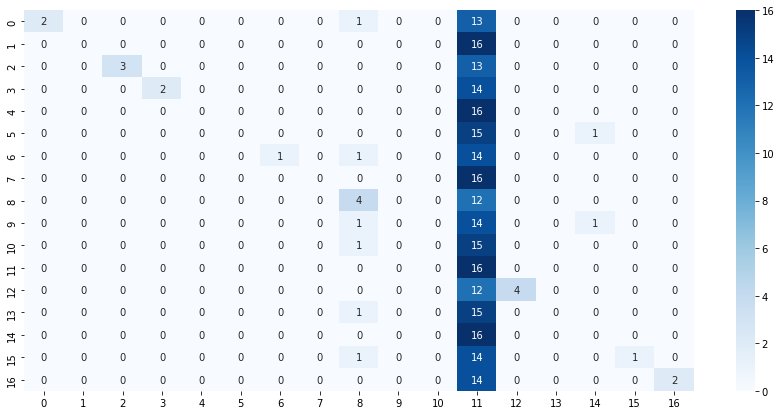

              precision    recall  f1-score   support

           0       1.00      0.12      0.22        16
           1       0.00      0.00      0.00        16
           2       1.00      0.19      0.32        16
           3       1.00      0.12      0.22        16
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        16
           6       1.00      0.06      0.12        16
           7       0.00      0.00      0.00        16
           8       0.40      0.25      0.31        16
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00        16
          11       0.07      1.00      0.12        16
          12       1.00      0.25      0.40        16
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        16
          15       1.00      0.06      0.12        16
          16       1.00      0.12      0.22        16

    accuracy              

In [38]:
model_svc=SVC(C=100, gamma=0.01, kernel='rbf', random_state=random_state)
model_svc.fit(X_flower_svm_train, y_flower_train)
y_svm_flower_predict=model_svc.predict(X_flower_svm_test)

print("Accuracy score Training dataset:{:.2f}".format(model_svc.score(X_flower_svm_train, y_flower_train)))
print("Accuracy score Testing dataset:{:.2f}".format(model_svc.score(X_flower_svm_test, y_flower_test)))

plt.figure(figsize=(15,7))
sns.heatmap(confusion_matrix(y_flower_test, y_svm_flower_predict), annot=True, fmt='d', cmap='Blues')
plt.show()

print(classification_report(y_flower_test,y_svm_flower_predict))

In [39]:
del model_svc

### C. Train a model using Neural Network and share performance metrics on test data.

In [40]:
y_flower_cat_train=keras.utils.to_categorical(y_flower_train)
y_flower_cat_test=keras.utils.to_categorical(y_flower_test)
y_flower_cat_train.shape,y_flower_cat_test.shape

((1088, 17), (272, 17))

In [41]:
backend.clear_session()
tf.random.set_seed(random_state)

model_keras = Sequential()

model_keras.add(Flatten(input_shape=(224,224,3)))
model_keras.add(BatchNormalization())

model_keras.add(Dense(512,activation='relu'))
model_keras.add(BatchNormalization())
model_keras.add(Dropout(0.1))

model_keras.add(Dense(256,activation='relu'))
model_keras.add(BatchNormalization())
model_keras.add(Dropout(0.1))

model_keras.add(Dense(128,activation='relu'))
model_keras.add(BatchNormalization())
model_keras.add(Dropout(0.1))

model_keras.add(Dense(64,activation='relu'))
model_keras.add(BatchNormalization())
model_keras.add(Dropout(0.1))

model_keras.add(Dense(17, activation='softmax'))

adam = Adam(learning_rate=0.0001)
model_keras.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Looking into our base model
model_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 batch_normalization (BatchN  (None, 150528)           602112    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [42]:
# Fit the model
model_keras_history=model_keras.fit(X_flower_train, y_flower_cat_train, validation_data=(X_flower_test, y_flower_cat_test) , epochs=50, batch_size=100, verbose=1)

Train on 1088 samples, validate on 272 samples
Epoch 1/50
1088/1088 [==============================] - 2s 1ms/sample - loss: 2.8325 - acc: 0.1728 - val_loss: 6.0561 - val_acc: 0.0588
Epoch 2/50
1088/1088 [==============================] - 1s 973us/sample - loss: 2.0310 - acc: 0.3603 - val_loss: 4.2246 - val_acc: 0.0588
Epoch 3/50
1088/1088 [==============================] - 1s 1ms/sample - loss: 1.7354 - acc: 0.4807 - val_loss: 3.1082 - val_acc: 0.0919
Epoch 4/50
1088/1088 [==============================] - 1s 1ms/sample - loss: 1.5013 - acc: 0.5781 - val_loss: 2.7310 - val_acc: 0.1324
Epoch 5/50
1088/1088 [==============================] - 1s 1ms/sample - loss: 1.2869 - acc: 0.6700 - val_loss: 2.5704 - val_acc: 0.1838
Epoch 6/50
1088/1088 [==============================] - 1s 1ms/sample - loss: 1.1500 - acc: 0.7040 - val_loss: 2.4881 - val_acc: 0.2537
Epoch 7/50
1088/1088 [==============================] - 1s 1ms/sample - loss: 1.0051 - acc: 0.7675 - val_loss: 2.4453 - val_acc: 0.2941

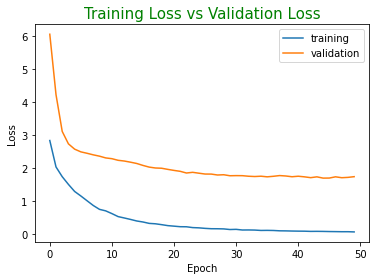

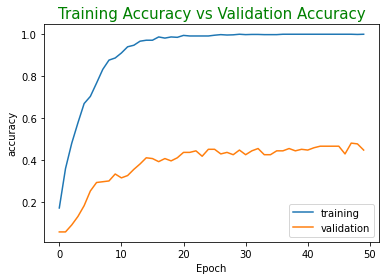

In [43]:
# Capturing learning history per epoch
model_keras_hist  = pd.DataFrame(model_keras_history.history)
model_keras_hist['epoch'] = model_keras_history.epoch

# Plotting Loss at different epochs
plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
plt.plot(model_keras_hist['loss'])
plt.plot(model_keras_hist['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

# Plotting Accuracy at different epochs
plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
plt.plot(model_keras_hist['acc'])
plt.plot(model_keras_hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

In [44]:
# calculate score of training data
model_keras.evaluate(X_flower_train, y_flower_cat_train, batch_size=100, verbose=1)

[0.018548270331366974, 1.0]

In [45]:
# calculate score of training data
model_keras.evaluate(X_flower_test, y_flower_cat_test, batch_size=100, verbose=1)

[1.7357249522910398, 0.44852942]

In [46]:
y_flower_pred=model_keras.predict(X_flower_test)
y_flower_pred_final=np.argmax(y_flower_pred, axis = 1)

In [47]:
print('Classification Report')
print(classification_report(y_flower_test,y_flower_pred_final))

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.31      0.43        16
           1       0.43      0.38      0.40        16
           2       0.62      0.62      0.62        16
           3       0.25      0.19      0.21        16
           4       0.40      0.50      0.44        16
           5       0.29      0.38      0.32        16
           6       0.38      0.56      0.45        16
           7       0.42      0.62      0.50        16
           8       0.59      0.62      0.61        16
           9       0.40      0.38      0.39        16
          10       0.44      0.50      0.47        16
          11       0.25      0.06      0.10        16
          12       0.83      0.62      0.71        16
          13       0.86      0.38      0.52        16
          14       0.26      0.31      0.29        16
          15       0.25      0.44      0.32        16
          16       0.86      0.75      0.80        16

    

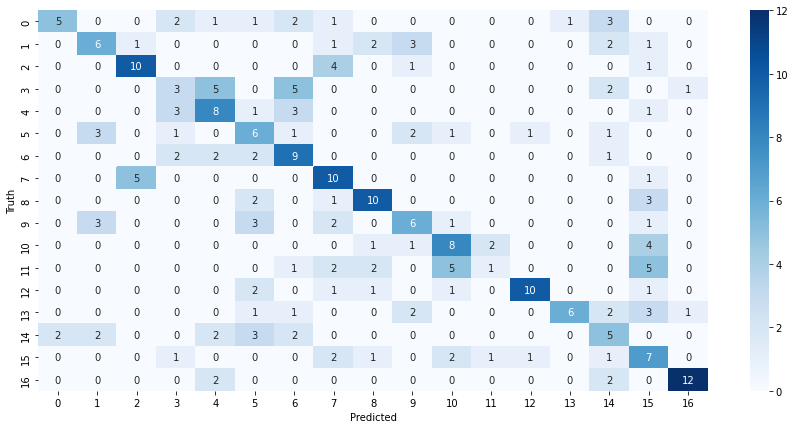

In [48]:
cm=confusion_matrix(y_flower_test,y_flower_pred_final)

plt.figure(figsize=(15,7))
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [49]:
del model_keras, model_keras_history, model_keras_hist

### D. Train a model using a basic CNN and share performance metrics on test data.

In [50]:
backend.clear_session()
tf.random.set_seed(random_state)

mobilenet_conv=MobileNet(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers except for the last layer: 
for layer in mobilenet_conv.layers[:-4]:
    layer.trainable = False

# Create the model
model_cv = Sequential()
 
# Add the MobileNet convolutional base model
model_cv.add(mobilenet_conv)
 
# Add new layers
model_cv.add(Flatten())

model_cv.add(Dense(1024, activation='relu'))
model_cv.add(Dropout(0.5))

model_cv.add(Dense(512, activation='relu'))
model_cv.add(Dropout(0.3))

model_cv.add(Dense(17, activation='softmax'))
model_cv.summary() 

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [51]:
model_cv.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-4),
              metrics=['acc', 'top_k_categorical_accuracy'])


In [52]:
# Fit the model
model_cv_history=model_cv.fit(X_flower_train, y_flower_cat_train, validation_data=(X_flower_test, y_flower_cat_test) , epochs=50, batch_size=50, verbose=1, callbacks=callbacks)

Train on 1088 samples, validate on 272 samples
Epoch 1/50
1088/1088 [==============================] - ETA: 0s - loss: 6.5958 - acc: 0.3511 - top_k_categorical_accuracy: 0.6949
Epoch 1: saving model to model_weights.h5
1088/1088 [==============================] - 6s 5ms/sample - loss: 6.5958 - acc: 0.3511 - top_k_categorical_accuracy: 0.6949 - val_loss: 1.4025 - val_acc: 0.6618 - val_top_k_categorical_accuracy: 0.9449 - lr: 2.0000e-04
Epoch 2/50
1088/1088 [==============================] - ETA: 0s - loss: 1.0467 - acc: 0.7390 - top_k_categorical_accuracy: 0.9623
Epoch 2: saving model to model_weights.h5
1088/1088 [==============================] - 3s 3ms/sample - loss: 1.0467 - acc: 0.7390 - top_k_categorical_accuracy: 0.9623 - val_loss: 0.5983 - val_acc: 0.8088 - val_top_k_categorical_accuracy: 0.9779 - lr: 2.0000e-04
Epoch 3/50
1088/1088 [==============================] - ETA: 0s - loss: 0.6116 - acc: 0.8483 - top_k_categorical_accuracy: 0.9844
Epoch 3: saving model to model_weights.

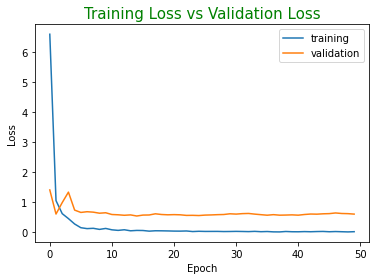

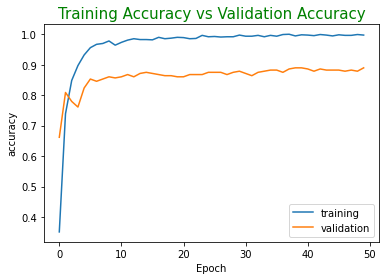

In [53]:
# Capturing learning history per epoch
model_cv_hist  = pd.DataFrame(model_cv_history.history)
model_cv_hist['epoch'] = model_cv_history.epoch

# Plotting Loss at different epochs
plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
plt.plot(model_cv_hist['loss'])
plt.plot(model_cv_hist['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

# Plotting Accuracy at different epochs
plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
plt.plot(model_cv_hist['acc'])
plt.plot(model_cv_hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

In [54]:
# calculate score of training data
model_cv.evaluate(X_flower_train, y_flower_cat_train, batch_size=50, verbose=1)

[0.08326470112832099, 0.97518384, 1.0]

In [55]:
# calculate score of training data
model_cv.evaluate(X_flower_test, y_flower_cat_test, batch_size=50, verbose=1)

[0.5965054149410742, 0.8897059, 0.9816176]

In [56]:
y_flower_pred=model_cv.predict(X_flower_test)
y_flower_pred_final=np.argmax(y_flower_pred, axis = 1)

In [57]:
print('Classification Report')
print(classification_report(y_flower_test,y_flower_pred_final))

Classification Report
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       1.00      1.00      1.00        16
           2       0.84      1.00      0.91        16
           3       1.00      0.69      0.81        16
           4       0.71      0.94      0.81        16
           5       0.64      1.00      0.78        16
           6       1.00      0.94      0.97        16
           7       0.84      1.00      0.91        16
           8       1.00      0.88      0.93        16
           9       1.00      0.94      0.97        16
          10       1.00      0.50      0.67        16
          11       0.94      1.00      0.97        16
          12       1.00      0.88      0.93        16
          13       1.00      0.69      0.81        16
          14       0.87      0.81      0.84        16
          15       0.94      1.00      0.97        16
          16       1.00      0.88      0.93        16

    

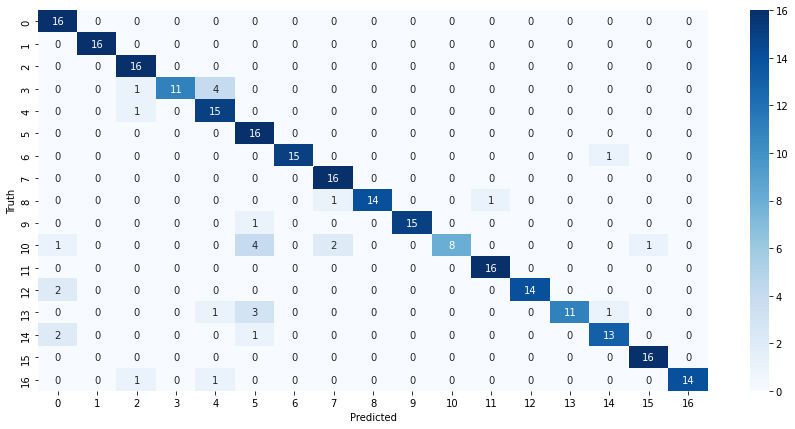

In [58]:
cm=confusion_matrix(y_flower_test,y_flower_pred_final)

plt.figure(figsize=(15,7))
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### E. Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label.

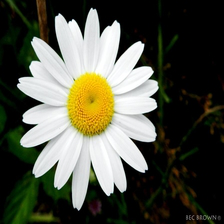

In [59]:
Image.open('/content/drive/My Drive/GL/Prediction - Flower.jpg')

In [60]:
img_arr = cv2.imread('/content/drive/My Drive/GL/Prediction - Flower.jpg', cv2.IMREAD_COLOR)/255.
np.argmax(model_cv.predict(np.reshape(img_arr, [1, 224, 224, 3])))

2

2 is predicted label for provided image.

In [61]:
del model_cv, model_cv_history, model_cv_hist